# ДЗ 5. Рекуррентные нейронные сети

-  Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).  
- Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?  

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Flatten, Conv1D, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing import timeseries_dataset_from_array
from keras.layers.recurrent import SimpleRNN, LSTM, GRU

import warnings
warnings.simplefilter("ignore")

In [36]:
# Colab
# !wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O data/airline-passengers.csv

In [37]:
# Local
# !python -m wget https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb -o data/airline-passengers.csv

In [38]:
# загрузка файла
import urllib.request
url = 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb'
filename = 'data/airline-passengers.csv'
urllib.request.urlretrieve(url, filename)

('data/airline-passengers.csv', <http.client.HTTPMessage at 0x1df4195d488>)

In [39]:
df = pd.read_csv('data/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [40]:
# скорректируем названия фич
df.columns = ['Date', 'Passengers']
# разделим дату на год и месяц и добавим как новые фичи
temp = df['Date'].str.split("-", expand=True)
df['Year'] = temp[0]
df['Month'] = temp[1]
df = df.drop('Date', axis=1)
df.head()

,Passengers,Year,Month
0,112,1949,01
1,118,1949,02
2,132,1949,03
3,129,1949,04
4,121,1949,05


In [41]:
# разбиваем выборку на трейн и тест
train_size = 100

# список признаков, по которым будем обучать
features = ['Passengers', 'Year', 'Month']

# отступ теста от тренировки
bias = 5

# делим
train_data = df.iloc[:train_size][features]
val_data = df.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

In [42]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [43]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

In [44]:
train_data.head()

,Passengers,Year,Month
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


In [45]:
train_data.tail()

,Passengers,Year,Month
95,306,1.376468,1.626840
96,315,1.791067,-1.534863
97,301,1.791067,-1.247435
98,356,1.791067,-0.960008
99,348,1.791067,-0.672580


In [46]:
# установка параметров нейросети
result = pd.DataFrame(columns=['Model', 'Train', 'Test', 'Test loss', 'Test accuracy'])

# длина истории
x_len = 7

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 16
epochs = 50


start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = df.iloc[start:end][target].values

x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = df.iloc[label_start:][target].values

8 108
31 113


In [47]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (31, 2), (31,))

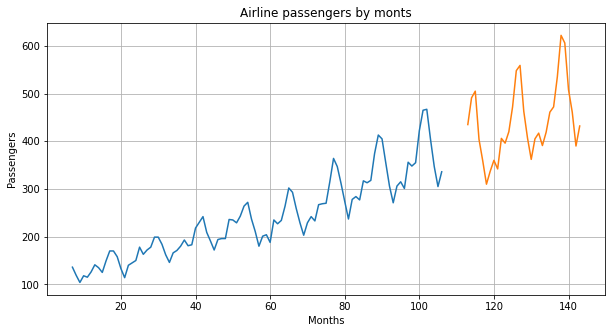

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(df.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(df.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.title('Airline passengers by monts')
plt.show()

In [49]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (16, 7, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]
 [-1.52572369 -0.38515289]
 [-1.52572369 -0.09772536]
 [-1.52572369  0.18970217]
 [-1.52572369  0.4771297 ]], shape=(7, 2), dtype=float64)
Target shape: (16,)
tf.Tensor(119, shape=(), dtype=int64)


## RNN

In [50]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Conv1D(64, 3, activation='linear'))
model.add(Conv1D(64, 1, activation='linear'))
model.add(Flatten())
model.add(Dense(3, activation='linear'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 7, 32)             1120      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 963       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 12,455
Trainable params: 12,455
Non-trainable params: 0
__________________________________________________

In [51]:
# компиляция модели
model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mae'])

In [52]:
# обучение модели
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/50
6/6 [==============================] - 1s 33ms/step - loss: 39705.0865 - mae: 188.7499 - val_loss: 190047.0469 - val_mae: 430.9945
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 39141.8853 - mae: 187.0063 - val_loss: 188640.1562 - val_mae: 429.3768
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 39150.6822 - mae: 187.2814 - val_loss: 187207.5938 - val_mae: 427.7232
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 39160.9467 - mae: 187.5608 - val_loss: 185621.6875 - val_mae: 425.8814
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 39141.8781 - mae: 187.7888 - val_loss: 183522.5938 - val_mae: 423.4224
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 39074.4640 - mae: 187.9723 - val_loss: 180380.4375 - val_mae: 419.7014
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 38920.0184 - mae: 188.0922 - val_loss: 175357.5000 - val_mae: 413.6674
Epoch 

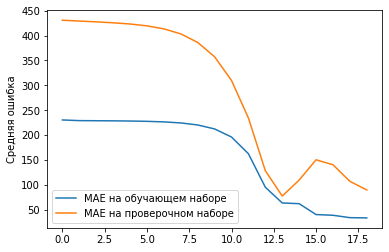

In [53]:
plt.plot(history.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [54]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

In [55]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

Epoch 1/50
6/6 [==============================] - 0s 29ms/step - loss: 1631.5465 - mae: 32.0749 - val_loss: 13139.8877 - val_mae: 93.2900
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 1398.2128 - mae: 28.8287 - val_loss: 14886.9678 - val_mae: 102.4782
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 1301.4154 - mae: 27.6915 - val_loss: 14532.1035 - val_mae: 101.4749
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 1187.0504 - mae: 26.5506 - val_loss: 12929.7773 - val_mae: 94.3432
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 1139.2882 - mae: 25.9284 - val_loss: 11976.7061 - val_mae: 90.1119
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 1084.4668 - mae: 25.1028 - val_loss: 11824.9512 - val_mae: 89.8752
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 1019.5815 - mae: 24.2177 - val_loss: 11584.5947 - val_mae: 89.1575
Epoch 8/50
6/6 [================

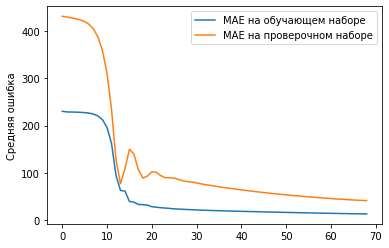

In [56]:
plt.plot(hist_train, 
         label='MAE на обучающем наборе')
plt.plot(hist_val, 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [57]:
# Проверяем результаты
pred_1 = model.predict(dataset_train).flatten()
pred_val1 = model.predict(dataset_val).flatten()

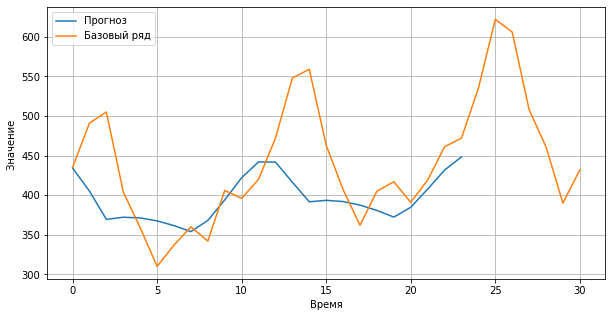

In [58]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

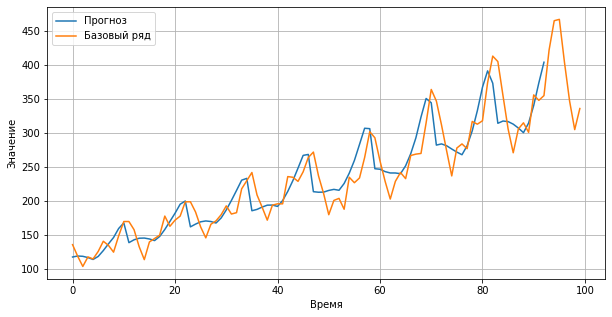

In [59]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [60]:
# метрики
train_loss, train_accuracy = model.evaluate(dataset_train)
test_loss, test_accuracy = model.evaluate(dataset_val)
print(f'train_loss: {train_loss}, train_accuracy: {train_accuracy}')
print(f'test_loss: {test_loss}, test_accuracy: {test_accuracy}')

2/2 [==============================] - 0s 2ms/step - loss: 2989.5610 - mae: 41.5698
train_loss: 310.1066589355469, train_accuracy: 13.306652069091797
test_loss: 2989.56103515625, test_accuracy: 41.56980895996094


In [61]:
new_row = {'Model':'RNN', 'Train':train_loss, 'Test':train_accuracy, \
           'Test loss':round(test_loss, 3), 'Test accuracy':round(test_accuracy, 3)}

result = result.append(new_row, ignore_index=True)

In [62]:
result

,Model,Train,Test,Test loss,Test accuracy
0,RNN,310.106659,13.306652,2989.561,41.57


## LSTM

In [63]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model2 = Sequential()

model2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model2.add(LSTM(32, return_sequences=True))
model2.add(Conv1D(64, 3, activation='linear'))
model2.add(Conv1D(64, 1, activation='linear'))
model2.add(Flatten())
model2.add(Dense(3, activation='linear'))
model2.add(Dense(1, activation='linear'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 32)             4480      
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 963       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [64]:
# компиляция модели
model2.compile(loss='mse', 
               optimizer='adam', 
               metrics=['mae'])

In [65]:
# обучение модели
history2 = model2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/50
6/6 [==============================] - 2s 93ms/step - loss: 39578.6443 - mae: 188.7319 - val_loss: 186716.5938 - val_mae: 427.1185
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 39493.7104 - mae: 188.4923 - val_loss: 186489.2812 - val_mae: 426.8530
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 39393.4185 - mae: 188.2370 - val_loss: 186075.6562 - val_mae: 426.3690
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 39183.2514 - mae: 187.7011 - val_loss: 185151.4062 - val_mae: 425.2860
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 38702.2374 - mae: 186.4730 - val_loss: 182927.0000 - val_mae: 422.6694
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 37567.8276 - mae: 183.5536 - val_loss: 177527.8125 - val_mae: 416.2540
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 34910.2630 - mae: 176.5463 - val_loss: 164725.2969 - val_mae: 400.6413
Epoch 

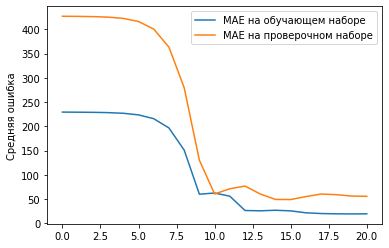

In [66]:
plt.plot(history2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [67]:
hist_val2 = history2.history['val_mae']
hist_train2 = history2.history['mae']

In [68]:
history2 = model2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

hist_val2.extend(history2.history2['val_mae'][:])
hist_train2.extend(history2.history2['mae'][:])

Epoch 1/50
6/6 [==============================] - 0s 25ms/step - loss: 633.2804 - mae: 19.2893 - val_loss: 5236.1426 - val_mae: 56.0502
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 615.4946 - mae: 19.0414 - val_loss: 5088.5981 - val_mae: 55.2694
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 603.8959 - mae: 18.9931 - val_loss: 4842.0332 - val_mae: 53.9042
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 594.4368 - mae: 18.8751 - val_loss: 4731.6699 - val_mae: 53.2873
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 582.0974 - mae: 18.6324 - val_loss: 4740.6201 - val_mae: 53.3785
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 569.1884 - mae: 18.3865 - val_loss: 4719.5317 - val_mae: 53.2885
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 557.3032 - mae: 18.1982 - val_loss: 4629.0801 - val_mae: 52.7855
Epoch 8/50
6/6 [==============================] 

AttributeError: 'History' object has no attribute 'history2'

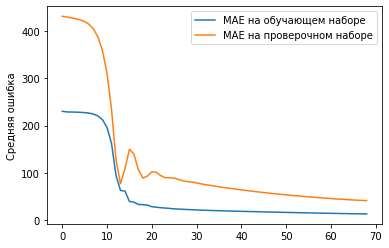

In [69]:
plt.plot(hist_train, 
         label='MAE на обучающем наборе')
plt.plot(hist_val, 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [70]:
# Проверяем результаты
pred_2 = model2.predict(dataset_train).flatten()
pred_val2 = model2.predict(dataset_val).flatten()

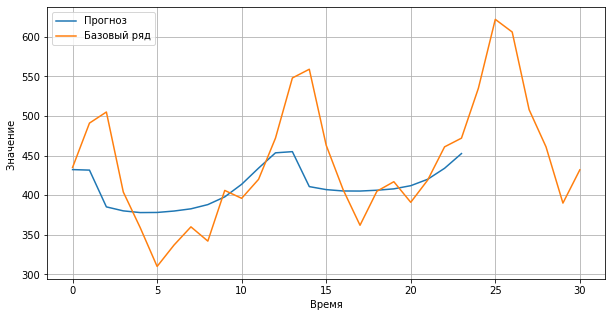

In [71]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

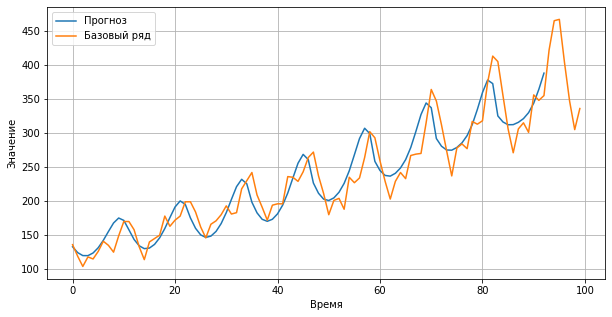

In [72]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [73]:
# метрики
train_loss, train_accuracy = model2.evaluate(dataset_train)
test_loss, test_accuracy = model2.evaluate(dataset_val)
print(f'train_loss: {train_loss}, train_accuracy: {train_accuracy}')
print(f'test_loss: {test_loss}, test_accuracy: {test_accuracy}')

2/2 [==============================] - 0s 2ms/step - loss: 2201.7986 - mae: 36.7429
train_loss: 308.0728454589844, train_accuracy: 13.733355522155762
test_loss: 2201.798583984375, test_accuracy: 36.74293518066406


In [74]:
new_row = {'Model':'LSTM', 'Train':train_loss, 'Test':train_accuracy, \
           'Test loss':round(test_loss, 3), 'Test accuracy':round(test_accuracy, 3)}

result = result.append(new_row, ignore_index=True)

In [75]:
result

,Model,Train,Test,Test loss,Test accuracy
0,RNN,310.106659,13.306652,2989.561,41.570
1,LSTM,308.072845,13.733356,2201.799,36.743


## GRU

In [76]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
hidden_size = 32

In [77]:
model3 = Sequential()
model3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=True
    )
)
model3.add(Conv1D(64, 3, activation='linear'))
model3.add(Conv1D(64, 1, activation='linear'))
model3.add(Flatten())
model3.add(Dense(3, activation='linear'))
model3.add(Dense(1, activation='linear'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 32)             3456      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 963       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 4         
Total params: 14,791
Trainable params: 14,791
Non-trainable params: 0
__________________________________________________

In [78]:
# # компиляция модели
model3.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mae'])

In [79]:
# обучение модели
history3 = model3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/50
6/6 [==============================] - 1s 50ms/step - loss: 39599.0315 - mae: 188.7908 - val_loss: 186814.5469 - val_mae: 427.2339
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 39549.3898 - mae: 188.6420 - val_loss: 186662.8594 - val_mae: 427.0573
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 39529.8848 - mae: 188.6066 - val_loss: 186455.8438 - val_mae: 426.8160
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 39495.5366 - mae: 188.5392 - val_loss: 186123.0000 - val_mae: 426.4273
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 39425.7952 - mae: 188.3932 - val_loss: 185519.7188 - val_mae: 425.7211
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 39280.6406 - mae: 188.0786 - val_loss: 184369.4219 - val_mae: 424.3709
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 38973.9132 - mae: 187.3975 - val_loss: 182123.5156 - val_mae: 421.7227
Epoch 

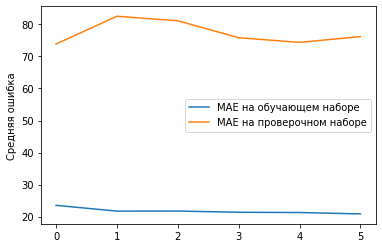

In [83]:
plt.plot(history3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [84]:
hist_val3 = history3.history['val_mae']
hist_train3 = history3.history['mae']

In [85]:
history3 = model3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

hist_val3.extend(history3.history3['val_mae'][:])
hist_train3.extend(history3.history3['mae'][:])

Epoch 1/50
6/6 [==============================] - 0s 16ms/step - loss: 761.9677 - mae: 20.3582 - val_loss: 8821.3750 - val_mae: 77.0117
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 741.9138 - mae: 20.1539 - val_loss: 8494.0840 - val_mae: 75.3597
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 729.2945 - mae: 20.0691 - val_loss: 8114.2607 - val_mae: 73.4284
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 719.2167 - mae: 19.9387 - val_loss: 7954.9956 - val_mae: 72.6702
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 704.6895 - mae: 19.7003 - val_loss: 7901.8374 - val_mae: 72.4972
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 689.6931 - mae: 19.5020 - val_loss: 7773.1802 - val_mae: 71.9032
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 676.8301 - mae: 19.3744 - val_loss: 7576.1450 - val_mae: 70.9844
Epoch 8/50
6/6 [==============================] 

AttributeError: 'History' object has no attribute 'history3'

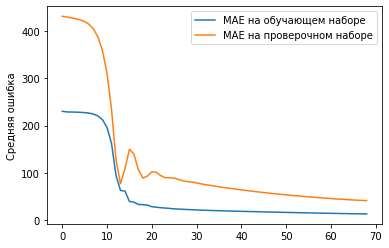

In [86]:
plt.plot(hist_train, 
         label='MAE на обучающем наборе')
plt.plot(hist_val, 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [87]:
# Проверяем результаты
pred_3 = model3.predict(dataset_train).flatten()
pred_val3 = model3.predict(dataset_val).flatten()

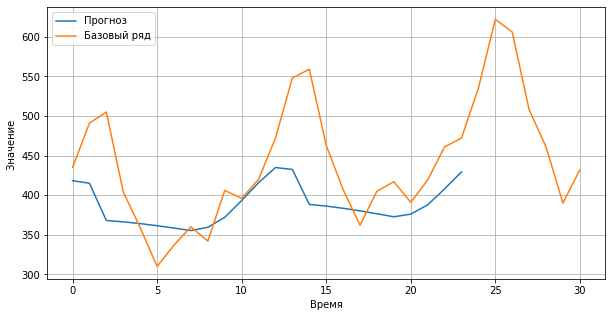

In [88]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

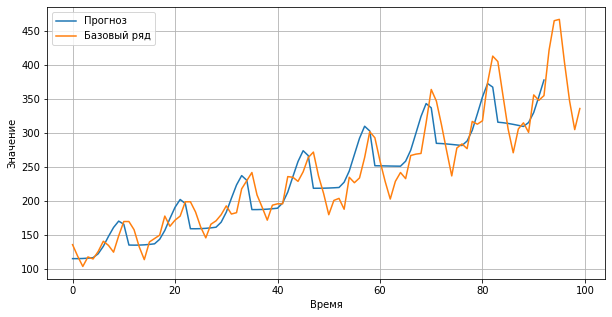

In [89]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [90]:
# метрики
train_loss, train_accuracy = model3.evaluate(dataset_train)
test_loss, test_accuracy = model3.evaluate(dataset_val)
print(f'train_loss: {train_loss}, train_accuracy: {train_accuracy}')
print(f'test_loss: {test_loss}, test_accuracy: {test_accuracy}')

2/2 [==============================] - 0s 998us/step - loss: 3468.8403 - mae: 48.6188
train_loss: 389.3922424316406, train_accuracy: 15.451492309570312
test_loss: 3468.84033203125, test_accuracy: 48.618770599365234


In [91]:
new_row = {'Model':'GRU', 'Train':train_loss, 'Test':train_accuracy, \
           'Test loss':round(test_loss, 3), 'Test accuracy':round(test_accuracy, 3)}

result = result.append(new_row, ignore_index=True)

In [92]:
result

,Model,Train,Test,Test loss,Test accuracy
0,RNN,310.106659,13.306652,2989.561,41.570
1,LSTM,308.072845,13.733356,2201.799,36.743
2,GRU,389.392242,15.451492,3468.840,48.619


## Итоги 

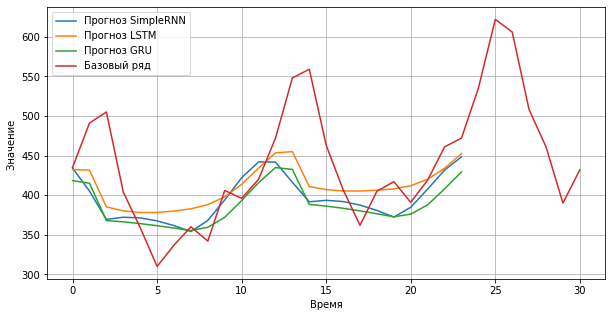

In [94]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val2[future + start: future + start + step], 
         label='Прогноз LSTM')
plt.plot(pred_val3[future + start: future + start + step], 
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

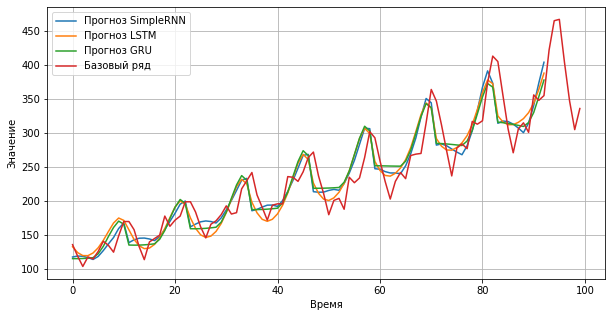

In [95]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

**Выводы**  
- Лучший результат показала модель LSTM  
- И чем больше итераций, тепм качество моделей лучше  